In [1]:
# pip install imgkit
# !pip install playwright
# !playwright install

In [2]:
cd ..

/home/vule/projects/learn_agent


**Screenshot**

In [3]:
input_fn = "data/sample.html"
html_image_fn = "data/html_image.png"
designed_image_fn = "data/designed_image.png"

In [4]:
from src.screenshot import take_screenshot
# Run the async function
await take_screenshot(input_fn, html_image_fn)


Screenshot saved as 'data/html_image.png'


In [5]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# load html_image_fn image, resize and save it back
image = Image.open(html_image_fn)
resize_image = image.resize((800, 600))
resize_image.save(f'{html_image_fn.split(".")[0]}_resized.png')

# load designed_image_fn image, resize and save it back
image = Image.open(designed_image_fn)
resize_image = image.resize((800, 600))
resize_image.save(f'{designed_image_fn.split(".")[0]}_resized.png')


In [6]:
# !pip install langchain-google-genai

In [7]:
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from src.key import gemini_api_key
from langchain_google_genai import ChatGoogleGenerativeAI
import base64

def load_base64(fn):
    with open(fn, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    google_api_key=gemini_api_key
)

from langchain.schema import HumanMessage, SystemMessage
import io

# Load and encode the image
designed_image = load_base64(designed_image_fn.split(".")[0] + "_resized.png")
html_image = load_base64(html_image_fn.split(".")[0] + "_resized.png")

# Create messages with image
prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You are a Frontend Developer. You are given a htmlwebpage screenshot and a designed image."),
    ("human", [
        {"type": "text", "text": "Tell me what html should be changed to make the designed image."},
        {"type": "image_url", "image_url": {
            "url": f"data:image/png;base64,{designed_image}", 
            "name": "designed_image.png"
        }},
        {"type": "image_url", "image_url": {
            "url": f"data:image/png;base64,{html_image}",
            "name": "html_image.png"
        }}
    ])
])

# messages = prompt_template.invoke({'designed_image': designed_image, 'html_image': html_image})
# messages.messages

# # Get response from LLM
# response = llm.invoke(messages)
# print(response)


/home/vule/miniconda3/envs/learn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)
/home/vule/miniconda3/envs/learn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from langchain_core.output_parsers.openai_tools import (
    JsonOutputToolsParser,
    PydanticToolsParser,
)

class Reflection(BaseModel):
    missing_elements: list[str] = Field(description="The missing elements.")
    wrong_position: list[str] = Field(description="The wrong position of the elements.")
    score: int = Field(description="The similarity score of the designed image and the html image, from 0 to 10", ge=0, le=10)
    is_identical: bool = Field(description="Whether the designed image and the html image are identical.")
    @property
    def normalized_score(self) -> float:
        return self.score / 10

    @property
    def is_good_score(self) -> bool:
        return self.normalized_score >= 0.8
    

parser = PydanticToolsParser(tools=[Reflection])

# create reflection chain
reflection_chain = prompt_template | llm.bind_tools(tools=[Reflection], tool_choice="Reflection")

# run the chain
reflection = reflection_chain.invoke({'designed_image': designed_image, 'html_image': html_image})

reflection

AIMessage(content='', additional_kwargs={'function_call': {'name': 'Reflection', 'arguments': '{"is_identical": true, "score": 10.0, "missing_elements": [], "wrong_position": []}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-72bb6758-f957-4057-a34b-91eee165fded-0', tool_calls=[{'name': 'Reflection', 'args': {'is_identical': True, 'score': 10.0, 'missing_elements': [], 'wrong_position': []}, 'id': '79f93397-525e-4e4b-ab90-165ffc83abe2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 665, 'output_tokens': 11, 'total_tokens': 676, 'input_token_details': {'cache_read': 0}})

In [9]:
# Convert image to html file 
designed_image_64 = load_base64(designed_image_fn.split(".")[0] + "_resized.png")

# creat a from to covert image to html file
prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You are a Frontend Developer. You are given a designed image."),
    ("human", [
        {"type": "text", "text": "Convert the designed image to html file with tailwind css."},
        {"type": "image_url", "image_url": {
            "url": f"data:image/png;base64,{designed_image_64}", 
            "name": "designed_image.png"
        }}
    ]),
    ("human", [
        {"type": "text", "text": "<note>Add tailwind css to the html file.</note>"}
    ])
])


# define output format
class HtmlContent(Reflection):
    html_content: str = Field(description="The html content with tailwind css.")

generate_image_parser = PydanticToolsParser(tools=[HtmlContent])

generate_image_chain = prompt_template | llm.bind_tools(tools=[HtmlContent], tool_choice="HtmlContent") | generate_image_parser

html_content = generate_image_chain.invoke({'designed_image': designed_image_64})
html_content


[HtmlContent(missing_elements=[], wrong_position=[], score=10, is_identical=True, html_content='<!DOCTYPE html>\\n<html lang=\\"en\\">\\n<head>\\n    <meta charset=\\"UTF-8\\">\\n    <meta name=\\"viewport\\" content=\\"width=device-width, initial-scale=1.0\\">\\n    <title>Welcome to Our Website</title>\\n    <script src=\\"https://cdn.tailwindcss.com\\"></script>\\n</head>\\n<body class=\\"bg-gray-100\\">\\n    <nav class=\\"bg-blue-500 p-4\\">\\n        <div class=\\"container mx-auto flex justify-between items-center\\">\\n            <div class=\\"text-white font-bold text-xl\\">Brand</div>\\n            <div class=\\"text-white\\">\\n                <a href=\\"#\\" class=\\"mr-4\\">Home</a>\\n                <a href=\\"#\\" class=\\"mr-4\\">About</a>\\n                <a href=\\"#\\" class=\\"mr-4\\">Services</a>\\n                <a href=\\"#\\">Contact</a>\\n            </div>\\n        </div>\\n    </nav>\\n\\n    <header class=\\"bg-blue-500 py-20\\">\\n        <div class=\\"

In [10]:
import json
print(html_content[0].html_content)

# # write the html content to a file
with open("data/auto_gen.html", "w") as f:
    html = html_content[0].html_content.encode().decode('unicode-escape')
    f.write(html)

html

# html_content


<!DOCTYPE html>\n<html lang=\"en\">\n<head>\n    <meta charset=\"UTF-8\">\n    <meta name=\"viewport\" content=\"width=device-width, initial-scale=1.0\">\n    <title>Welcome to Our Website</title>\n    <script src=\"https://cdn.tailwindcss.com\"></script>\n</head>\n<body class=\"bg-gray-100\">\n    <nav class=\"bg-blue-500 p-4\">\n        <div class=\"container mx-auto flex justify-between items-center\">\n            <div class=\"text-white font-bold text-xl\">Brand</div>\n            <div class=\"text-white\">\n                <a href=\"#\" class=\"mr-4\">Home</a>\n                <a href=\"#\" class=\"mr-4\">About</a>\n                <a href=\"#\" class=\"mr-4\">Services</a>\n                <a href=\"#\">Contact</a>\n            </div>\n        </div>\n    </nav>\n\n    <header class=\"bg-blue-500 py-20\">\n        <div class=\"container mx-auto text-center\">\n            <h1 class=\"text-white text-5xl font-bold mb-4\">Welcome to Our Website</h1>\n            <p class=\"text-whi

'<!DOCTYPE html>\n<html lang="en">\n<head>\n    <meta charset="UTF-8">\n    <meta name="viewport" content="width=device-width, initial-scale=1.0">\n    <title>Welcome to Our Website</title>\n    <script src="https://cdn.tailwindcss.com"></script>\n</head>\n<body class="bg-gray-100">\n    <nav class="bg-blue-500 p-4">\n        <div class="container mx-auto flex justify-between items-center">\n            <div class="text-white font-bold text-xl">Brand</div>\n            <div class="text-white">\n                <a href="#" class="mr-4">Home</a>\n                <a href="#" class="mr-4">About</a>\n                <a href="#" class="mr-4">Services</a>\n                <a href="#">Contact</a>\n            </div>\n        </div>\n    </nav>\n\n    <header class="bg-blue-500 py-20">\n        <div class="container mx-auto text-center">\n            <h1 class="text-white text-5xl font-bold mb-4">Welcome to Our Website</h1>\n            <p class="text-white text-lg mb-8">This is a sample page b

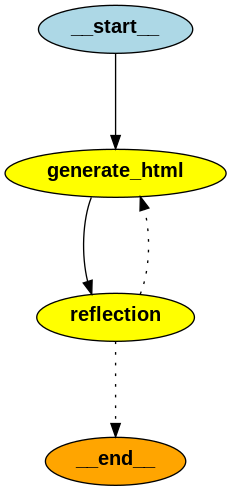

In [16]:
from typing import Literal
from typing import Literal, Any
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AIMessage, AnyMessage
from langchain_core.pydantic_v1 import BaseModel, Field

# define state of the graph
class State(TypedDict):
    # the full tree
    #    {"type": "image_url", "image_url": {
    #         "url": f"data:image/png;base64,{html_image}",
    #         "name": "html_image.png"
    #     }}
    designed_image: Any = Field(description="Base64 encoded designed image.")
    messages: list[AnyMessage] = Field(description="The messages of the graph.", optional=True)
    candidate_html_content: list[AIMessage] = Field(description="The candidate html content with tailwind css.", optional=True)


# create nodes
def generate_html_function(state: State) -> State:
    pass

def reflection_function(state: State) -> State:
    pass

def check_score(state: State):
    pass

graph = StateGraph(State)

graph.add_node('generate_html', generate_html_function)
graph.add_node('reflection', reflection_function)

graph.add_edge(START, 'generate_html')
graph.add_edge('generate_html', 'reflection')

graph.add_conditional_edges('reflection', check_score, ['generate_html', END])

egraph = graph.compile()

from IPython.display import Image

Image(egraph.get_graph().draw_png())

